# Lab 8: Cluster Computing in Dask with RCC and AWS

## A Quick Start of Using Dask Locally

Today we are going to learn about [**Dask**](https://dask.org/), a powerful and comprehensive cluster computing library in python. To install
dask on your local machine, just run the following command:

`python -m pip install "dask[complete]"`

It is recommended to use the "complete" syntax here, which would automatically install all the core packages in dask. Besides, when running on the RCC system, where the python environment is managed by anaconda, it is highly recommended to create a virtual environment to hold dask. You can either run `conda install dask` or the command above to install dask in your conda environment.

To use dask on a local single machine (e.g., your laptop), there is nothing else to install. You could simply run the following commands to start a local cluster:

In [1]:
from dask.distributed import Client,LocalCluster
cluster = LocalCluster()

F:\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
F:\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In a local cluster, the default number of processes started equals to the number of cpus on the local machine. To adjust the number of workers (processes) in dask, you can use the scale method as below.

In [8]:
cluster.scale(4) #your number of processes

Dask provides users with a convenient interface to monitor the usage and status of the workers in the cluster. To open the monitor, you just need to type `localhost:8787` after launching the cluster. 8787 is the default port number for the diagonastic server, you can also customize the port number by specifying the `dashboard_address` argument when setting up the cluster. More options to customize the local cluster configuration could be found [here](https://docs.dask.org/en/latest/setup/single-distributed.html).


<img src="./dask_worker monitor.png">

To use the resources in the cluster, we need a scheduler to coordinate the operation and storage of the data, and this is why the client object in dask comes into being. The client object provides some functions similar to pool.map (map) and pool.apply (submit) in python multiprocessing, and also functions analogous to the scatter and gather methods in MPI4PY to handle large iterable objects and collect map results. Below it's a simple example of how to use these methods in dask, and all the data operation methods and data types, which we would mention in a moment, can all be used in the same way once the cluster is configured properly, no matter on a single machine or in a multi-node system (RCC) or a cloud computing platform (AWS).

In [5]:
client = Client(cluster)
def digit_sum(x):
    string = str(x)
    return sum([int(c) for c in string])

In [18]:
import numpy as np

# submit single jobs and get the result
result_future = client.submit(digit_sum,1234)
result_future.result()

10

In [24]:
# submit map jobs and get the result
results_future = client.map(digit_sum, np.random.randint(1e+8,1e+9,int(1e+4)))
results = client.gather(results_future)
results[:10]

[26, 28, 41, 49, 41, 26, 29, 41, 48, 35]

Alternatively, we can firstly scatter the data before mapping, this is useful when elements in the iterable are large. This generally works for python built-in iterables like list, tuple, set and dictionaries. For numpy arrays, please use client.map directly or dask.array to parallelize.

In [62]:
data_future = client.scatter({x:y for x,y in enumerate(np.random.randint(1e+8,1e+9,20))})
data_future

{0: <Future: status: finished, type: int32, key: 0>,
 1: <Future: status: finished, type: int32, key: 1>,
 2: <Future: status: finished, type: int32, key: 2>,
 3: <Future: status: finished, type: int32, key: 3>,
 4: <Future: status: finished, type: int32, key: 4>,
 5: <Future: status: finished, type: int32, key: 5>,
 6: <Future: status: finished, type: int32, key: 6>,
 7: <Future: status: finished, type: int32, key: 7>,
 8: <Future: status: finished, type: int32, key: 8>,
 9: <Future: status: finished, type: int32, key: 9>,
 10: <Future: status: finished, type: int32, key: 10>,
 11: <Future: status: finished, type: int32, key: 11>,
 12: <Future: status: finished, type: int32, key: 12>,
 13: <Future: status: finished, type: int32, key: 13>,
 14: <Future: status: finished, type: int32, key: 14>,
 15: <Future: status: finished, type: int32, key: 15>,
 16: <Future: status: finished, type: int32, key: 16>,
 17: <Future: status: finished, type: int32, key: 17>,
 18: <Future: status: finished

In [66]:
results_future = client.map(digit_sum, data_future.values())
results = client.gather(results_future)
results[:10]

[46, 37, 37, 49, 23, 34, 56, 46, 54, 65]

From this example, you see that dask would not directly send back the computation result but store them in the future objects instead. Future objects are stored in the shared memory for each processes. An advantage of this mechanism is that it can avoid unnecessary communications between processes, which cost extra time. This design is suitable for build up process pipelines, where we would have one or more intermediate results to pass through the whole process. That is to say, you can pass the intermediate data to another client.map function for further computation without the effort to manually send the data from local process to the shared memory.     

Dask also provides interface for users to check the address, status, etc. of individual workers in code by defining the Nanny object. To check this, call cluster.workers and its affliated functions  

In [21]:
cluster.workers

[<Nanny: tcp://127.0.0.1:65199, threads: 1>,
 <Nanny: tcp://127.0.0.1:65138, threads: 1>,
 <Nanny: tcp://127.0.0.1:65141, threads: 1>,
 <Nanny: tcp://127.0.0.1:65151, threads: 1>]

In [22]:
[x.status for x in cluster.workers]

['running', 'running', 'running', 'running']

To restart (this means killing all currently running jobs and cleaning the memory) run the following, the restarted worker could have a different address:

In [15]:
worker_index = 0
cluster.workers[worker_index].restart(timeout=10)

<Future pending cb=[coroutine.<locals>.wrapper.<locals>.<lambda>() at F:\Anaconda3\lib\site-packages\tornado\gen.py:226]>

To restart the cluster, use `client.restart()`. To shut down the local cluster, use `cluster.close()`. You do not have to manually shut down the client session since it would end as long as the python kernel is terminated. 

## Running Dask in RCC

In the following tutorial, we are going to use the same datasets in the spark session to get you familiar with using dask in a multi-node cluster computing environment, the RCC system. And we would still use the example of classifying the ratings of books to show the details of deploying dask in machine learning tasks.

Ideally, we should be able to read the product review dataset from Amazon S3 using [dask.read_parquet](https://docs.dask.org/en/latest/dataframe-api.html?highlight=read_parquet#dask.dataframe.read_parquet). However, the RCC system is designed to block Internet connection on the compute nodes, which would be used as components of our Dask cluster. So we are unable to use Dask to parallelly read the external datasets from S3 on RCC. To make it work, we have manually downloaded the book review datasets to the directory of our class resource on RCC ('/project2/macs30123/'), and we can read the data "locally" on RCC now.  

To use the nodes of RCC with dask, we need to install both dask and dask-jobqueue modules in our conda environment as follow. The [dask-jobqueue](https://jobqueue.dask.org/en/latest/) is used to deploy dask on common job queuing systems like PBS (used in SSD acropolis) and Slurm (used in RCC). It allows us to automatically generate sbatch scripts and directly submit them to the job manager system interactively in jupyter notebook.  

In [2]:
! pip install "dask[complete]" dask-jobqueue --upgrade #conda install dask-jobqueue -c conda-forge

Requirement already up-to-date: dask[complete] in /home/cytwill/.conda/envs/github_env/lib/python3.8/site-packages (2.30.0)
Requirement already up-to-date: dask-jobqueue in /home/cytwill/.conda/envs/github_env/lib/python3.8/site-packages (0.7.1)


To construct a cluster on RCC system, we use the SLURMCluster of the RCC system to define our sbatch scripts. The "queue" argument specifies the partition to which you would like to submit your jobs; the "core" argument specifies the number of cpus you would like to use for each node (not the entire number of cpus); the "memory" argument defines the total memory allocation for a single node in the cluster, which is evenly distributed over all cpus; the "process" argument integrate cores into subgroups and for most pythonic jobs it is recommmended to make each process hold one cpu to avoid the [Global Interpreter Lock](https://realpython.com/python-gil/); the 'interface' argument is used to define the type of network interface linking different nodes, which in our case is the infiniband interconnect (ib0).       

In [ ]:
import dask_jobqueue as jobq

cluster = jobq.SLURMCluster(queue='broadwl',cores=10, memory='40GB',processes=10,
                            walltime='01:00:00', interface='ib0', job_extra=['--account=macs30123']
                            #job_extra=['--output=dask_worker.out',
                            #           '--error=dask_worker.err']
                           )

According to the printed information (if none, use the default port number 8787), we can open the monitor at `localhost:[port-number]`. By default, there are no workers started at this moment, you can check the generated sbatch script, which is just like our sbatch files, before finally submitting the jobs to the queue system by using the scale methods, which would create the multi-node cluster needed by our parallel analysis.

In [2]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p broadwl
#SBATCH -n 1
#SBATCH --cpus-per-task=10
#SBATCH --mem=38G
#SBATCH -t 03:00:00
#SBATCH --account=pi-jevans

/home/cytwill/.conda/envs/github_env/bin/python -m distributed.cli.dask_worker tcp://172.25.220.71:38954 --nthreads 1 --nprocs 10 --memory-limit 4.00GB --name name --nanny --death-timeout 60 --interface ib0



The assignment of the client object is an important step to connect the dask backend to the cluster you just specified. Otherwise, they would just run on a local cluster (which is forbidden by RCC). 

In [3]:
# allocate 2 nodes to the cluster
cluster.scale(jobs=2)

# connect the local machine to the nodes
from dask.distributed import Client
client = Client(cluster)

Dask was developed in coordination with other widely used python community projects like Numpy, Pandas, and Scikit-Learn. Like Spark, Dask provides users with parallelized arrays ([dask.array](https://docs.dask.org/en/latest/array.html)), dataframes ([dask.dataframe](https://docs.dask.org/en/latest/dataframe.html)) to store and process large dataset. It also includes a parallelized version of general python collection objects ([dask.bag](https://docs.dask.org/en/latest/bag.html)) for users to implement operations like map and filter. You would practice using these dask data types in courses on datacamp. For this section, we would primarily use the dask dataframes and arrays to finish the machine learning tasks. 

In [4]:
import dask.dataframe as dd

# load the book review data
df = dd.read_csv('/project2/macs30123/AWS_book_reviews/*.csv')

The * symbol above is specially used in dask to read in multiple datasets in a parallel way.

In [5]:
# take a look
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year
0,US,15444933,R1WWG70WK9VUCH,1848192576,835940987,Standing Qigong for Health and Martial Arts - ...,5,9,10,N,Y,Informative AND interesting!,"After attending a few Qigong classes, I wanted...",2015-05-02,2015
1,US,20595117,R1EQ3POS0RIOD5,145162445X,574044348,A Universe from Nothing: Why There Is Somethin...,4,4,7,N,N,Between 'Nothing' and 'Nothing' somehow we are...,Krauss traces the remarkable transformation in...,2012-06-29,2012
2,US,52925878,R10SRJA4VVGUBD,055341805X,846590203,Hyacinth Girls: A Novel,4,0,0,Y,N,Mysteries upon mysteries,"Rebecca, a dental hygienist, receives a call a...",2015-05-02,2015
3,US,40062567,RD3268X41GM7U,0425263908,119148606,Bared to You,5,1,1,N,N,"""RAW, STEAMY, HYPNOTIC!""","\\""BARED TO YOU\\"" is a sizzling, red-hot pass...",2012-06-29,2012
4,US,47221489,R3KGQL5X5BSJE1,1416556141,987400385,Healer: A Novel,5,0,0,N,Y,Well written story,Good characters and plot line. I spent a pleas...,2015-05-02,2015


In [6]:
df.dtypes

marketplace          object
customer_id           int64
review_id            object
product_id           object
product_parent        int64
product_title        object
star_rating           int64
helpful_votes         int64
total_votes           int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
year                  int64
dtype: object

In [7]:
df.shape

(Delayed('int-2e984e0b-6079-4183-a58b-a12176e7e6d7'), 15)

In [8]:
df.shape[0].compute()

20726160

In [9]:
df.describe().compute()

,customer_id,product_parent,star_rating,helpful_votes,total_votes,year
count,2.072616e+07,2.072616e+07,2.072616e+07,2.072616e+07,2.072616e+07,2.072616e+07
mean,3.287233e+07,5.012232e+08,4.340540e+00,3.836475e+00,5.332147e+00,2.010451e+03
std,1.545060e+07,2.878609e+08,1.125604e+00,2.240867e+01,2.581018e+01,4.506381e+00
min,1.002400e+04,5.760000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.995000e+03
25%,2.888019e+07,2.623204e+08,4.000000e+00,0.000000e+00,1.000000e+00,2.010000e+03
50%,4.314521e+07,5.120222e+08,5.000000e+00,1.000000e+00,2.000000e+00,2.013000e+03
75%,5.259045e+07,7.577690e+08,5.000000e+00,7.000000e+00,9.000000e+00,2.014000e+03
max,5.309659e+07,9.999999e+08,5.000000e+00,2.755000e+04,2.872700e+04,2.015000e+03


According to the above data exploration, we could see that the dask dataset has many methods that are analogous to the functions in [pandas](https://pandas.pydata.org/docs/reference/index.html), so it would be very easy-to-use if you are already familiar with pandas. One major difference is the use of delay mechanism in dask dataframes, which is revealed by the compute() function. This means that dataframe operations would not be executed unless the compute method is called, and this would trigger all previously called related operations to be performed like a pipeline.  

### Preprocessing

Next we are going to perform the preprocessing for the book review dataset to obtain our features and labels for the machine learning task. Based on our intuition, id_like attributes are not likely to provide much useful information. Other attributes like total_votes and helpful_votes might contain more useful information about the ratings of books. We can make a mean calculation based on the groupby results to check our speculations. 

In [7]:
# do a groupby operation
df.groupby(by='marketplace').mean().compute()

,customer_id,product_parent,star_rating,helpful_votes,total_votes,year
marketplace,,,,,,
DE,4.196011e+07,5.047194e+08,4.358941,2.360758,3.647635,2005.886768
FR,3.075995e+07,5.214875e+08,4.308173,2.785668,3.946417,2011.635635
JP,3.667752e+07,5.157488e+08,4.452929,6.054778,8.073038,2009.791874
UK,3.263059e+07,5.065183e+08,4.363765,2.979392,4.290699,2012.018752
US,3.284676e+07,5.011147e+08,4.340153,3.851688,5.350379,2010.444432


Here we manually encoded the categorical of vine and verified_purchase. You can also do this in dask with the [OrdinalEncoder](https://ml.dask.org/modules/generated/dask_ml.preprocessing.OrdinalEncoder.html). 

In [10]:
# adding some coded features
df['vine_code'] = df['vine'].apply(lambda x:1 if x=='Y' else 0, meta=('vine', 'int64'))
df['verified_purchase_code'] = df['verified_purchase'].apply(lambda x:1 if x=='Y' else 0, meta=('vine', 'int64'))

In [11]:
df[['vine_code','verified_purchase_code']].head()

,vine_code,verified_purchase_code
0,0,1
1,0,0
2,1,0
3,0,0
4,0,1


In [28]:
# do a groupby operation
df.groupby(by='star_rating').mean().compute()

,customer_id,product_parent,helpful_votes,total_votes,year,vine_code,verified_purchase_code
star_rating,,,,,,,
1,3.447849e+07,5.016755e+08,9.876988,20.341088,2009.393735,0.003899,0.354239
2,3.533688e+07,5.006462e+08,6.476555,10.455063,2009.584428,0.019910,0.427630
3,3.446525e+07,5.004053e+08,4.549026,6.554343,2010.105793,0.033166,0.470260
4,3.394212e+07,5.005828e+08,3.130165,3.934887,2010.061811,0.029201,0.460472
5,3.212843e+07,5.014813e+08,3.281001,4.011696,2010.731501,0.007675,0.546666


Based on the results, it seems that our guesses are likely to be correct. For these numerical features, helpful_votes, total_votes, vine_code and verified_purchase_code would be included in our machine learning task.     

#### Text Preprocessing

All available feature engineering tools in dask are covered in [dask_ml](https://ml.dask.org/index.html), which we need to install first. To precess the text in dask, you can visit the [vectorizers](https://ml.dask.org/modules/generated/dask_ml.preprocessing.OrdinalEncoder.html) for more information. Noticing that the result of text processing are dask arrays with scipy sparse matrix internally. If you want to check the values in them, you need to use the toarray() or todense() methods.  

In [36]:
!pip install dask_ml --upgrade

     |████████████████████████████████| 141 kB 11.4 MB/s eta 0:00:01


In [12]:
# deal with missing values 
df[['review_body','review_headline']]=df[['review_body','review_headline']].fillna(value='empty')

In [13]:
from dask_ml import feature_extraction

vect = feature_extraction.text.HashingVectorizer(stop_words='english',n_features=64)
text_sparse_array = vect.fit_transform(df['review_body'])
text_sparse_array.compute_chunk_sizes()

dask.array<_transformer, shape=(20726160, 64), dtype=float64, chunksize=(129341, 64), chunktype=scipy.csr_matrix>

In [14]:
df['label'] = df['star_rating'].apply(lambda x:1 if x>3 else 0, meta=('star_rating', 'int64'))
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year,vine_code,verified_purchase_code,label
0,US,15444933,R1WWG70WK9VUCH,1848192576,835940987,Standing Qigong for Health and Martial Arts - ...,5,9,10,N,Y,Informative AND interesting!,"After attending a few Qigong classes, I wanted...",2015-05-02,2015,0,1,1
1,US,20595117,R1EQ3POS0RIOD5,145162445X,574044348,A Universe from Nothing: Why There Is Somethin...,4,4,7,N,N,Between 'Nothing' and 'Nothing' somehow we are...,Krauss traces the remarkable transformation in...,2012-06-29,2012,0,0,1
2,US,52925878,R10SRJA4VVGUBD,055341805X,846590203,Hyacinth Girls: A Novel,4,0,0,Y,N,Mysteries upon mysteries,"Rebecca, a dental hygienist, receives a call a...",2015-05-02,2015,1,0,1
3,US,40062567,RD3268X41GM7U,0425263908,119148606,Bared to You,5,1,1,N,N,"""RAW, STEAMY, HYPNOTIC!""","\\""BARED TO YOU\\"" is a sizzling, red-hot pass...",2012-06-29,2012,0,0,1
4,US,47221489,R3KGQL5X5BSJE1,1416556141,987400385,Healer: A Novel,5,0,0,N,Y,Well written story,Good characters and plot line. I spent a pleas...,2015-05-02,2015,0,1,1


In [15]:
df.groupby('label').count().compute()['star_rating']

label
0     3517710
1    17208450
Name: star_rating, dtype: int64

In [16]:
# Pick up some features we think of useful as features
num_feature_df = df[['helpful_votes','total_votes','vine_code','verified_purchase_code']]

It is useful to do some scaling here to decrease the effect of different scales for difffernt attributes. For different scale methods, you can see [here](https://ml.dask.org/modules/api.html#module-dask_ml.preprocessing)

In [17]:
from dask_ml.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_feature_df = scaler.fit_transform(num_feature_df)
num_feature_df.head()

,helpful_votes,total_votes,vine_code,verified_purchase_code
0,0.000327,0.000348,0.0,1.0
1,0.000145,0.000244,0.0,0.0
2,0.000000,0.000000,1.0,0.0
3,0.000036,0.000035,0.0,0.0
4,0.000000,0.000000,0.0,1.0


In [18]:
import dask.array
label_array = df['label'].to_dask_array().compute_chunk_sizes()
num_feature_array = num_feature_df.to_dask_array().compute_chunk_sizes()

It is worth mentioning the usage of compute_chunk_sizes(), this function computes and memorizes the original size and chunk size of the datasets which is useful for deciding how many samples we need for train and test sets. Previously, the total sample size of feature and label arrays are not known because they are distributed over the cluster nodes. 

### Machine Learning

Finally come to the train-test section. Actually, dask hoes not developed most of their machine learning models. They developed parallel interface for a resourceful machine learning package [scikit-learn](https://scikit-learn.org/stable/). So the way we run machine learning methods in dask is quite similar to using scikit-learn.   

In [19]:
# use the numerical features
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(num_feature_array, 
                                                  label_array,
                                                  train_size=0.7,test_size=0.3,
                                                  random_state=0)

In [20]:
X_train

dask.array<concatenate, shape=(14508174, 4), dtype=float64, chunksize=(90538, 4), chunktype=numpy.ndarray>

In [21]:
y_test

dask.array<concatenate, shape=(6217985,), dtype=int64, chunksize=(38803,), chunktype=numpy.ndarray>

In [25]:
# using class weights to mitigate data imbalance
class_counts = df.groupby('label').count().compute()['star_rating']

Dask allows you to use multiple models from sklearn, and here we use the SGD classifier to perform the machine learning task. As you can see from the code, we implement cross validation and hyperparameter searching in the model, which is the best part in machine learning tasks to be parallelized. The IncrementalSearchCV we used here is designed for models that have [partial_fit](https://ml.dask.org/modules/generated/dask_ml.wrappers.Incremental.html#) functions, like the SGDClassifier. These incremental learners can train on batches of data. This fits well with Dask’s blocked data structures. Besides, the use of hyper-parameter optimizer is also related to the constraint posed by memory and the increased complexity with more parameters. For details about how to choose this the optimizer, you could view [here](https://ml.dask.org/hyper-parameter-search.html?highlight=memory#scaling-hyperparameter-searches).

In [22]:
from dask_ml.model_selection import IncrementalSearchCV
from sklearn.linear_model import SGDClassifier
import numpy as np
#import joblib

clf = SGDClassifier(class_weight={0:1,1:class_counts[0]/class_counts[1]})
params = {'alpha': np.logspace(-4, 0, num=1000),
          'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
          'average': [True, False]}
#clf.fit(X_train, y_train)
#clf = Incremental(est, scoring='accuracy')
search = IncrementalSearchCV(clf, params)
search.fit(X_train, y_train, classes=[0,1])

/home/cytwill/.conda/envs/github_env/lib/python3.8/site-packages/dask_ml/model_selection/_incremental.py:995: FutureWarning: decay_rate has been deprecated since Dask-ML v1.4.0.

    * Use InverseDecaySearchCV to use `decay_rate`
    * Specify decay_rate=None


  warn(


IncrementalSearchCV(estimator=SGDClassifier(class_weight={0: 1,
                                                          1: 0.20441759716883276}),
                    parameters={'alpha': array([1.00000000e-04, 1.00926219e-04, 1.01861017e-04, 1.02804473e-04,
       1.03756668e-04, 1.04717682e-04, 1.05687597e-04, 1.06666496e-04,
       1.07654461e-04, 1.08651577e-04, 1.09657929e-04, 1.10673602e-04,
       1.11698682e-04, 1.12733256e-04, 1.13777413e-04, 1.14831241e-...
       8.39312950e-01, 8.47086827e-01, 8.54932707e-01, 8.62851257e-01,
       8.70843150e-01, 8.78909065e-01, 8.87049689e-01, 8.95265713e-01,
       9.03557835e-01, 9.11926760e-01, 9.20373200e-01, 9.28897872e-01,
       9.37501502e-01, 9.46184819e-01, 9.54948564e-01, 9.63793480e-01,
       9.72720319e-01, 9.81729841e-01, 9.90822810e-01, 1.00000000e+00]),
                                'average': [True, False],
                                'loss': ['hinge', 'log', 'modified_huber',
                                     

In [23]:
# check the best parameter
search.best_estimator_

SGDClassifier(alpha=0.53917746403875,
              class_weight={0: 1, 1: 0.20441759716883276})

In [24]:
# check the train accuracy
search.best_score_

0.8309756144504109

In [25]:
# check the test accuracy
search.best_estimator_.score(X_test,y_test)

0.8302773326085541

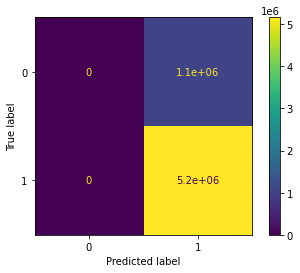

In [26]:
# plot the confusion matrix
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt
plot_confusion_matrix(search.best_estimator_, X_test, y_test)
plt.show()

This primitive model suffers a lot from data imbalance even after we specified weights. So you may need to find some other ways to reduce this negative effect in your assignments.

In [22]:
# use all the features
from dask_ml.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(text_sparse_array,
                                                  label_array,
                                                  train_size=0.7,test_size=0.3,
                                                  random_state=0)

In [23]:
X_train

dask.array<concatenate, shape=(14508174, 64), dtype=float64, chunksize=(90538, 64), chunktype=numpy.ndarray>

In [26]:
from sklearn.linear_model import SGDClassifier
import dask_ml

sgd = SGDClassifier(class_weight={0:1,1:class_counts[0]/class_counts[1]})
clf = dask_ml.wrappers.Incremental(
    sgd, scoring='accuracy',
)
clf.fit(X_train,y_train, classes=[0, 1])

Incremental(estimator=SGDClassifier(class_weight={0: 1,
                                                  1: 0.20441759716883276}),
            scoring='accuracy')

In [27]:
clf.score(X_train,y_train)

0.5948509440264502

In [28]:
clf.score(X_test,y_test)

0.5947751562604284

In [29]:
X_test_array = X_test.compute().toarray()

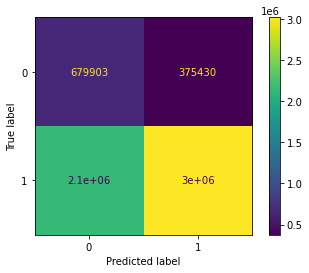

In [30]:
# plot the confusion matrix
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt
plot_confusion_matrix(clf.estimator_, X_test_array, y_test)
plt.show()

From the result here, we see that both of the two models have some drawbacks. Using the numerical (including categorical) features yield a result of high bias while using the pure text-based (review-body) features makes the overall accuracy very low. What about use both of these features? It's your turn to try! However, I have to notify you that the sparse matrix generated by the text vectors do not function well with many models, as it has some structural differences with ordinary arrays (like shape). So you might need to think about a feasible way to transfer the text vectors to normal numpy arrays and reload it to dask (This sounds somewhat inefficient, if you have better ideas, please let us know~).  